In [1]:
import SigDelRFF
import numpy as np
import scipy
import math

In [2]:
#Set number of data points
N = 1000
N_train = 900
N_test = N - N_train
d = 5
#Set sigma for RBF kernel
sigma = math.sqrt(2.5)

#Generate Data matrix X with shape N x 5
X,y,eps = SigDelRFF.GenerateData(N,d)

#Curate train, test features and true labels
y_train = y[:N_train]
y_test = y[N_train:]
eps_test = eps[N_train:]

#Compute the RBF Kernel
K = SigDelRFF.RBFkernel(sigma,X,N_train)  

In [3]:
RFF_errors = []
NS_errors = []
Tilde1_errors = []
Tilde2_errors = []
Stoc_errors = []
StocTilde1_errors = []
StocTilde2_errors = []

mlist = []
for i in range(0,7):
    mlist.append(150+i*150)

mlist = np.asarray(mlist,dtype=int)
print(mlist)

[ 150  300  450  600  750  900 1050]


In [4]:
#Peform quantization for various feature lenghts
for iterr in range(mlist.size):
    
    print(mlist[iterr])
    m = int(mlist[iterr])

    #Compute RFF features and RFF kernel
    Z = SigDelRFF.RFF_for_RBF(sigma,X,m,N,d)
    Z_train = Z[:N_train,:]
    Z_test = Z[N_train:, :]
    K_RFF = (2/m)*np.matmul(Z_train,Z_train.transpose())

    lambd_NS = 15
    beta = 1.9
    p_NS = int(m/lambd_NS)
    Q,U = SigDelRFF.NoiseShapeQuant(Z,lambd_NS,beta)
    Z_NS = SigDelRFF.NoiseShapeCondense(Q,p_NS,lambd_NS,beta)
    Z_NS_train = Z_NS[:N_train,:]
    Z_NS_test  = Z_NS[N_train:,:]

    K_NS = np.matmul(Z_NS_train,Z_NS_train.transpose())

    lambd = 15
    p = int(m/lambd)

    #Set v for condensation in r=1 case
    DFT = scipy.linalg.dft(lambd)
    vR1 = DFT[0]
    vR1 = vR1.real
    vR1 = np.sign(vR1)

    #Set v for condensation in r=2 case
    r = 2
    vR2 = np.empty(lambd)
    lambd_tilde = int((lambd+r-1)/r)
    for i in range(0,lambd_tilde):
        vR2[i] = i+1
    k = 1    
    for i in range(lambd_tilde,lambd):
        vR2[i] =  lambd_tilde - k
        k = k+1

    #Perform Sigma-Delta quantization to the features for r=1
    Q,U = SigDelRFF.SigDel(Z,1,6)
    Z_tilde1 = SigDelRFF.Condense(Q,1,p,lambd,vR1)
    Z_tilde1_train = Z_tilde1[:N_train,:]
    Z_tilde1_test  = Z_tilde1[N_train:,:]
    K_tilde1 = np.matmul(Z_tilde1_train,Z_tilde1_train.transpose())

    #Perform Sigma-Delta quantization to the features for r=2, sigma=6
    Q,U = SigDelRFF.SigDel(Z,2,6)
    Z_tilde2 = SigDelRFF.Condense(Q,2,p,lambd,vR2)
    Z_tilde2_train = Z_tilde2[:N_train,:]
    Z_tilde2_test  = Z_tilde2[N_train:,:]
    K_tilde2 = np.matmul(Z_tilde2_train,Z_tilde2_train.transpose())  

    #Perform Stochastic quantization
    Q_stoc = np.empty((N,m))
    SigDelRFF.StocQuant(Q_stoc,Z,m,N)
    Z_stoc_train = math.sqrt(2/m)*Q_stoc[:N_train,:]
    Z_stoc_test  = math.sqrt(2/m)*Q_stoc[N_train:,:]
    K_stoc = np.matmul(Z_stoc_train,Z_stoc_train.transpose())    

    #Compute predictions via Woodbury formula and print relative MSE
    mu = 1

    #MSE for RFF
    tmp = np.matmul(np.transpose(Z_train),y_train)
    w  = np.matmul(np.linalg.inv(np.matmul(Z_train.transpose(),Z_train) + mu*np.eye(m)),tmp)
    predictions = np.matmul(Z_test,w)
    RFF_MSE  = np.mean(np.power(np.divide(predictions - (y_test-eps_test),y_test-eps_test),2))

    #MSE for Noise shaping
    tmp = np.matmul(np.transpose(Z_NS_train),y_train)
    w  = np.matmul(np.linalg.inv(np.matmul(Z_NS_train.transpose(),Z_NS_train) + mu*np.eye(p_NS)),tmp)
    predictions = np.matmul(Z_NS_test,w)
    NS_MSE  = np.mean(np.power(np.divide(predictions - (y_test-eps_test),y_test-eps_test),2))
    #NS_MSE  = np.mean(np.power(predictions - (y_test),2))

    #MSE for Sigma Del
    tmp = np.matmul(np.transpose(Z_tilde1_train),y_train)
    w  = np.matmul(np.linalg.inv(np.matmul(Z_tilde1_train.transpose(),Z_tilde1_train) + mu*np.eye(p)),tmp)
    predictions = np.matmul(Z_tilde1_test,w)
    Tilde1_MSE  = np.mean(np.power(np.divide(predictions - (y_test-eps_test),y_test-eps_test),2))
    #Tilde1_MSE  = np.mean(np.power(predictions - (y_test),2))

    tmp = np.matmul(np.transpose(Z_tilde2_train),y_train)
    w  = np.matmul(np.linalg.inv(np.matmul(Z_tilde2_train.transpose(),Z_tilde2_train) + mu*np.eye(p)),tmp)
    predictions = np.matmul(Z_tilde2_test,w)
    Tilde2_MSE  = np.mean(np.power(np.divide(predictions - (y_test-eps_test),y_test-eps_test),2))
    #Tilde2_MSE  = np.mean(np.power(predictions - (y_test),2))

    #MSE for Stochastic quantization
    tmp = np.matmul(np.transpose(Z_stoc_train),y_train)
    w  = np.matmul(np.linalg.inv(np.matmul(Z_stoc_train.transpose(),Z_stoc_train) + mu*np.eye(m)),tmp)
    predictions = np.matmul(Z_stoc_test,w)
    STOC_MSE  = np.mean(np.power(np.divide(predictions - (y_test-eps_test),y_test-eps_test),2))
    #STOC_MSE  = np.mean(np.power(predictions - (y_test),2))

    RFF_errors.append(RFF_MSE)
    NS_errors.append(NS_MSE)
    Tilde1_errors.append(Tilde1_MSE)
    Tilde2_errors.append(Tilde2_MSE)
    Stoc_errors.append(STOC_MSE)

150
300
450
600
750
900
1050


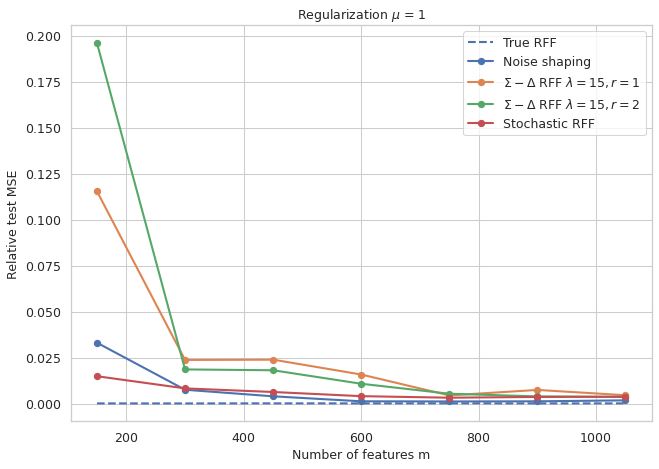

In [6]:
import matplotlib.pylab as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
small_size = 12
medium_size = 12
big_size = 14

plt.rcParams["figure.figsize"] = [10,7]
plt.rcParams["figure.dpi"] = 75
plt.rc('font', size=small_size)          
plt.rc('axes', titlesize=small_size)    
plt.rc('axes', labelsize=medium_size)    
plt.rc('xtick', labelsize=small_size)    
plt.rc('ytick', labelsize=small_size)    
plt.rc('legend', fontsize=small_size)    
plt.rc('figure', titlesize=big_size) 

fig, ax1 = plt.subplots(1,1)

ax1.plot(mlist,RFF_errors,'--b',mlist,NS_errors,'-o',mlist,Tilde1_errors,'-o',mlist,Tilde2_errors,'-o',
         mlist,Stoc_errors,'-o',linewidth=2, markersize=6)
ax1.set_xlabel("Number of features m")
ax1.set_ylabel("Relative test MSE")
ax1.legend(["True RFF","Noise shaping","$\Sigma-\Delta$ RFF $\lambda=15, r=1$",'$\Sigma-\Delta$ RFF $\lambda=15, r=2$'
            ,'Stochastic RFF'])
ax1.set_title("Regularization $\mu$ = " + str(mu))
#fig.savefig("Images/mse"+str(N_train)+"Ntrain_Dim"+str(d)+".png",dpi=200,bbox_inches="tight")